In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/MyDrive/NEXCO/src/EDA/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NEXCO/src/EDA


In [ ]:
!pip install japanize_matplotlib jpholiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ========================================
# Library
# ========================================
import os
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold
)# StratifiedGroupKFold, 
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

pd.set_option('display.max_columns', None)

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed()

In [ ]:
train_df = pd.read_csv("../train/train.csv")
search_spec_df = pd.read_csv("../train/search_data.csv")
search_unspec_df = pd.read_csv("../train/search_unspec_data.csv")
road_df = pd.read_csv("../train/road.csv")

In [ ]:
train_df.shape

(910080, 7)

In [ ]:
train_df.head(5)# (910080, 7)

,datetime,start_code,end_code,OCC,allCars,speed,is_congestion
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0


In [ ]:
search_spec_df.shape

(910080, 4)

In [ ]:
search_spec_df.head(5)# (910080, 4)

,datetime,start_code,end_code,search_1h
0,2021-04-08 00:00:00,1110210,1800006,15.0
1,2021-04-08 01:00:00,1110210,1800006,6.0
2,2021-04-08 02:00:00,1110210,1800006,3.0
3,2021-04-08 03:00:00,1110210,1800006,26.0
4,2021-04-08 04:00:00,1110210,1800006,31.0


In [ ]:
search_unspec_df.shape

(37920, 4)

In [ ]:
search_unspec_df.head(5)# (37920, 4)

,date,start_code,end_code,search_unspec_1d
0,2021-04-08,1110210,1800006,3448.0
1,2021-04-09,1110210,1800006,2992.0
2,2021-04-10,1110210,1800006,2970.0
3,2021-04-11,1110210,1800006,2992.0
4,2021-04-12,1110210,1800006,2974.0


In [ ]:
road_df.shape

(79, 18)

In [ ]:
road_df.head(5)# (79, 18)

,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code
0,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.90,下り,0.0,9.4,100,1800
1,京葉道路・館山自動車道接続部,市原,1130001,1130006,12,12,35.55136,35.49471,140.143014,140.094986,2.0,2.0,39.17,下り,35.7,43.7,100,1130
2,市原,京葉道路・館山自動車道接続部,1130006,1130001,12,12,35.49471,35.55136,140.094986,140.143014,2.0,2.0,39.17,上り,43.7,35.7,100,1130
3,市原,姉崎袖ヶ浦,1130006,1130016,12,12,35.49471,35.42603,140.094986,140.045153,2.0,2.0,46.27,下り,43.7,53.7,100,1130
4,姉崎袖ヶ浦,市原,1130016,1130006,12,12,35.42603,35.49471,140.045153,140.094986,2.0,2.0,46.27,上り,53.7,43.7,100,1130


In [ ]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    # search_spec_df = expand_datetime(search_spec_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    search_unspec_df['is_holiday'] = search_unspec_df['date'].map(lambda x: jpholiday.is_holiday(x))
    search_unspec_df['is_holiday'] = search_unspec_df['is_holiday'].astype(int)# is_holiday = jpholiday.is_holiday(date)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [ ]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [ ]:
train['section'] = train['start_code'].astype(str)+'_'+train['end_code'].astype(str)

train['straight_dist'] = np.sqrt( (train['end_lat']-train['start_lat'])**2 + (train['end_lng']-train['start_lng'])**2 ) * 100
train['KP_se_dist'] = np.abs(train['end_KP']-train['start_KP'])
train['KP_te_dist'] = np.abs(train['end_KP']-train['KP'])
train['KP_st_dist'] = np.abs(train['KP']-train['start_KP'])
train['KP_max_dist'] = np.max(train[['KP_te_dist', 'KP_st_dist']], axis=1) / train['KP_se_dist']
train['detour_rate'] = train['KP_se_dist']/train['straight_dist']

In [ ]:
'''
train                     :    (910080, 7) << 時間(24h*37920d), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)
search                 :     (910080, 4) << 時間(24h*37920d), sid, eid, 検索数
search_unspec   :    (37920, 4)    << 日付(37920d)         , sid, eid, 検索数
road                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP
                                                                eid, e名, e県id, e緯度, e経度, e接続IC数, eKP
                                                                上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)
                                                                
                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)
train_df, search_df, search_unspec_df, road_df

train < 時間 > search
train < 日付 > search_unspec
train < sid, eid > road

all_df >> 15+18
'''

'\ntrain                     :    (910080, 7) << 時間(24h*37920d), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)\nsearch                 :     (910080, 4) << 時間(24h*37920d), sid, eid, 検索数\nsearch_unspec   :    (37920, 4)    << 日付(37920d)         , sid, eid, 検索数\nroad                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP\n                                                                eid, e名, e県id, e緯度, e経度, e接続IC数, eKP\n                                                                上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)\n                                                                \n                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)\ntrain_df, search_df, search_unspec_df, road_df\n\ntrain < 時間 > search\ntrain < 日付 > search_unspec\ntrain < sid, eid > road\n\nall_df >> 15+18\n'

In [ ]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'dayofweek', 'is_holiday']
num_cols = ['year', 'month', 'day', 'hour', 'search_1h', 'search_unspec_1d', 'KP', 'start_KP', 'end_KP', 'limit_speed', 'straight_dist', 'KP_se_dist', 'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate']
feature_cols = cat_cols + num_cols

In [ ]:
train.head(5)

,datetime,start_code,end_code,OCC,allCars,speed,is_congestion,year,month,day,hour,search_1h,date,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code,dayofweek,section,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate
0,2021-04-08 00:00:00,0,11,2.083333,510,80.712329,0,2021,4,8,0,15.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,1,0.0,9.4,100,1,3,0,8.300286,9.4,5.5,3.9,0.585106,1.132491
1,2021-04-08 01:00:00,0,11,1.500000,433,81.730415,0,2021,4,8,1,6.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,1,0.0,9.4,100,1,3,0,8.300286,9.4,5.5,3.9,0.585106,1.132491
2,2021-04-08 02:00:00,0,11,1.333333,366,81.288828,0,2021,4,8,2,3.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,1,0.0,9.4,100,1,3,0,8.300286,9.4,5.5,3.9,0.585106,1.132491
3,2021-04-08 03:00:00,0,11,1.500000,426,82.953162,0,2021,4,8,3,26.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,1,0.0,9.4,100,1,3,0,8.300286,9.4,5.5,3.9,0.585106,1.132491
4,2021-04-08 04:00:00,0,11,1.833333,498,82.430862,0,2021,4,8,4,31.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,1,0.0,9.4,100,1,3,0,8.300286,9.4,5.5,3.9,0.585106,1.132491


In [ ]:
train.shape

(910080, 37)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910080 entries, 0 to 910079
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          910080 non-null  datetime64[ns]
 1   start_code        910080 non-null  int64         
 2   end_code          910080 non-null  int64         
 3   OCC               910080 non-null  float64       
 4   allCars           910080 non-null  int64         
 5   speed             910080 non-null  float64       
 6   is_congestion     910080 non-null  int64         
 7   year              910080 non-null  int64         
 8   month             910080 non-null  int64         
 9   day               910080 non-null  int64         
 10  hour              910080 non-null  int64         
 11  search_1h         910080 non-null  float64       
 12  date              910080 non-null  datetime64[ns]
 13  search_unspec_1d  910080 non-null  float64       
 14  is_h

In [ ]:
train.describe()

,start_code,end_code,OCC,allCars,speed,is_congestion,year,month,day,hour,search_1h,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code,dayofweek,section,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate
count,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.00000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.00000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000
mean,21.822785,21.810127,2.603678,873.231072,89.983847,0.004449,2021.441667,6.304167,15.900000,11.50000,22.567348,2062.439425,0.045833,11.696203,11.696203,36.237507,36.237356,139.301040,139.301227,2.202532,2.189873,93.675468,0.493671,94.317367,94.292051,92.911392,0.797468,3.01250,39.000000,6.312220,6.931241,3.657797,3.273443,0.724121,1.087087
std,12.218233,12.215452,2.571047,871.270962,7.946235,0.066553,0.496586,3.078689,8.743955,6.92219,51.064207,1808.973878,0.209124,1.759995,1.759995,0.609746,0.609727,0.399541,0.399440,0.536745,0.529532,61.921437,0.499960,62.098440,62.102722,9.566812,0.401886,1.99892,22.803521,3.483787,3.924388,3.320637,3.277406,0.138075,0.105186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,10.000000,10.000000,35.193970,35.193970,138.784267,138.784267,2.000000,2.000000,3.900000,0.000000,0.000000,0.000000,80.000000,0.000000,0.00000,0.000000,1.790517,1.600000,0.244000,0.330000,0.507692,0.855682
25%,12.000000,12.000000,0.916667,245.000000,87.000000,0.000000,2021.000000,4.000000,8.000000,5.75000,2.000000,706.000000,0.000000,10.000000,10.000000,35.839090,35.839090,139.018083,139.018083,2.000000,2.000000,46.270000,0.000000,47.500000,47.500000,80.000000,1.000000,1.00000,19.000000,4.391609,4.900000,1.190000,1.100000,0.585106,1.023384
50%,22.000000,22.000000,1.916667,513.000000,90.843137,0.000000,2021.000000,6.000000,16.000000,11.50000,8.000000,1469.000000,0.000000,11.000000,11.000000,36.252110,36.252110,139.122931,139.122931,2.000000,2.000000,76.000000,0.000000,78.700000,78.700000,100.000000,1.000000,3.00000,39.000000,6.028817,6.900000,3.080000,2.470000,0.725530,1.097473
75%,32.000000,32.000000,3.666667,1289.000000,94.157971,0.000000,2022.000000,9.000000,23.000000,17.25000,23.000000,2851.000000,0.000000,12.000000,12.000000,36.651900,36.651900,139.506467,139.506467,2.000000,2.000000,128.120000,1.000000,125.900000,125.900000,100.000000,1.000000,5.00000,59.000000,7.795043,8.495000,5.100000,4.000000,0.857143,1.148937
max,43.000000,43.000000,52.500000,5046.000000,120.000000,1.000000,2022.000000,12.000000,31.000000,23.00000,1400.000000,12793.000000,1.000000,15.000000,15.000000,37.390050,37.390050,140.143014,140.143014,4.000000,4.000000,237.700000,1.000000,238.600000,238.600000,100.000000,1.000000,6.00000,78.000000,23.597858,25.954000,25.152000,25.142000,0.969099,1.379507


In [ ]:
train.hist(figsize = (18,14)); # 一括でヒストグラムを描画する
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show()

In [ ]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    le_dict[c] = le

with open("../save/features/le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

100%|██████████| 7/7 [00:00<00:00, 16.13it/s]


In [ ]:
# ========================================
# training module
# ========================================
def f1(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred)
    return 'f1', score, True

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100,
               weight_dict: dict=None,
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        if weight_dict is None:
            print('Don\'t use sample weight.')
            lgb_train = lgb.Dataset(x_train, y_train)
        elif weight_dict[0] == 'balance':
            print('Using sample weight. {Balance}')
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
        else:
            print('Using sample weight.')
            print(weight_dict)
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight=weight_dict, y=y_train).astype('float32'))
            
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train, 
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['Train', 'Valid'],
                          feval=lgb_f1_score,
                          num_boost_round=100000,
                          verbose_eval=100,
                          categorical_feature=cat_cols,
                          callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
                         )# categorical_feature=categories, verbose_eval=10
        
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = f1_score(y_valid, (pred_i > 0.5).astype(int))
        print(f" - fold{i + 1} - {score:.4f} \n")
        
    score = f1_score(y, (oof_pred > 0.5).astype(int))

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models


In [ ]:
train['is_congestion'].value_counts()

0    906031
1      4049
Name: is_congestion, dtype: int64

In [ ]:
train['is_congestion'].value_counts() / len(train['is_congestion'])

0    0.995551
1    0.004449
Name: is_congestion, dtype: float64

In [ ]:
vc = train['is_congestion'].value_counts()
vc[0]/vc[1]

223.76660903926896

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.1,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}# 'num_leaves' : int(0.7 * 2 ** max_depth)

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:1.0, 1:5.0}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 37)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0363242	Train's f1: 0.558035	Valid's binary_logloss: 0.01784	Valid's f1: 0.471375
[200]	Train's binary_logloss: 0.028157	Train's f1: 0.634907	Valid's binary_logloss: 0.0154036	Valid's f1: 0.515464
[300]	Train's binary_logloss: 0.0240526	Train's f1: 0.676307	Valid's binary_logloss: 0.0144767	Valid's f1: 0.565437
[400]	Train's binary_logloss: 0.0210619	Train's f1: 0.706632	Valid's binary_logloss: 0.0140978	Valid's f1: 0.565093
Early stopping, best iteration is:
[310]	Train's binary_logloss: 0.0236793	Train's f1: 0.678816	Valid's binary_logloss: 0.0144514	Valid's f1: 0.570188
 - fold1 - 0.5702 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0366562	Train's f1: 0.550792	Valid's binary_logloss: 0.018581	Valid's f1: 0.43422
[200]	Train's binary_loglo

In [ ]:
"""
train shape: (910080, 31)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.038645	Train's f1: 0.549564	Valid's binary_logloss: 0.0187594	Valid's f1: 0.461756
[200]	Train's binary_logloss: 0.0308088	Train's f1: 0.608076	Valid's binary_logloss: 0.0166578	Valid's f1: 0.475593
[300]	Train's binary_logloss: 0.0260141	Train's f1: 0.655182	Valid's binary_logloss: 0.0154176	Valid's f1: 0.489684
[400]	Train's binary_logloss: 0.0227892	Train's f1: 0.68391	Valid's binary_logloss: 0.0148183	Valid's f1: 0.507003
[500]	Train's binary_logloss: 0.0204199	Train's f1: 0.70113	Valid's binary_logloss: 0.0144697	Valid's f1: 0.522346
[600]	Train's binary_logloss: 0.0183236	Train's f1: 0.729445	Valid's binary_logloss: 0.0141321	Valid's f1: 0.53
Early stopping, best iteration is:
[566]	Train's binary_logloss: 0.0189551	Train's f1: 0.719921	Valid's binary_logloss: 0.014296	Valid's f1: 0.531735
 - fold1 - 0.5317 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0380956	Train's f1: 0.548354	Valid's binary_logloss: 0.0189891	Valid's f1: 0.431965
[200]	Train's binary_logloss: 0.0297252	Train's f1: 0.627072	Valid's binary_logloss: 0.0169677	Valid's f1: 0.429173
Early stopping, best iteration is:
[124]	Train's binary_logloss: 0.0350519	Train's f1: 0.580834	Valid's binary_logloss: 0.0180635	Valid's f1: 0.447804
 - fold2 - 0.4478 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.036759	Train's f1: 0.562823	Valid's binary_logloss: 0.0196292	Valid's f1: 0.476117
[200]	Train's binary_logloss: 0.0289792	Train's f1: 0.626679	Valid's binary_logloss: 0.0175394	Valid's f1: 0.493267
Early stopping, best iteration is:
[148]	Train's binary_logloss: 0.0320934	Train's f1: 0.597984	Valid's binary_logloss: 0.0183125	Valid's f1: 0.497432
 - fold3 - 0.4974 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.035896	Train's f1: 0.56967	Valid's binary_logloss: 0.0219855	Valid's f1: 0.478261
[200]	Train's binary_logloss: 0.0286319	Train's f1: 0.633509	Valid's binary_logloss: 0.0206509	Valid's f1: 0.496436
[300]	Train's binary_logloss: 0.0245093	Train's f1: 0.666667	Valid's binary_logloss: 0.0202943	Valid's f1: 0.507463
Early stopping, best iteration is:
[291]	Train's binary_logloss: 0.0249323	Train's f1: 0.661534	Valid's binary_logloss: 0.0204115	Valid's f1: 0.514357
 - fold4 - 0.5144 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0371515	Train's f1: 0.573627	Valid's binary_logloss: 0.0218834	Valid's f1: 0.432866
[200]	Train's binary_logloss: 0.0293857	Train's f1: 0.63439	Valid's binary_logloss: 0.0194896	Valid's f1: 0.45265
[300]	Train's binary_logloss: 0.0250284	Train's f1: 0.665957	Valid's binary_logloss: 0.0182761	Valid's f1: 0.46564
Early stopping, best iteration is:
[289]	Train's binary_logloss: 0.0255784	Train's f1: 0.661496	Valid's binary_logloss: 0.018344	Valid's f1: 0.481194
 - fold5 - 0.4812 

==================================================
FINISH: CV Score: 0.4947
"""

"\ntrain shape: (910080, 31)\nUsing sample weight.\n{0: 1.0, 1: 5.0}\nTraining until validation scores don't improve for 100 rounds.\n[100]\tTrain's binary_logloss: 0.038645\tTrain's f1: 0.549564\tValid's binary_logloss: 0.0187594\tValid's f1: 0.461756\n[200]\tTrain's binary_logloss: 0.0308088\tTrain's f1: 0.608076\tValid's binary_logloss: 0.0166578\tValid's f1: 0.475593\n[300]\tTrain's binary_logloss: 0.0260141\tTrain's f1: 0.655182\tValid's binary_logloss: 0.0154176\tValid's f1: 0.489684\n[400]\tTrain's binary_logloss: 0.0227892\tTrain's f1: 0.68391\tValid's binary_logloss: 0.0148183\tValid's f1: 0.507003\n[500]\tTrain's binary_logloss: 0.0204199\tTrain's f1: 0.70113\tValid's binary_logloss: 0.0144697\tValid's f1: 0.522346\n[600]\tTrain's binary_logloss: 0.0183236\tTrain's f1: 0.729445\tValid's binary_logloss: 0.0141321\tValid's f1: 0.53\nEarly stopping, best iteration is:\n[566]\tTrain's binary_logloss: 0.0189551\tTrain's f1: 0.719921\tValid's binary_logloss: 0.014296\tValid's f1: 0

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.05,
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = None
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 37)
Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.00744965	Train's f1: 0.670311	Valid's binary_logloss: 0.0133558	Valid's f1: 0.554707
Early stopping, best iteration is:
[72]	Train's binary_logloss: 0.0082173	Train's f1: 0.648821	Valid's binary_logloss: 0.013355	Valid's f1: 0.5581
 - fold1 - 0.5581 

Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.00869773	Train's f1: 0.642898	Valid's binary_logloss: 0.0203469	Valid's f1: 0.443555
Early stopping, best iteration is:
[25]	Train's binary_logloss: 0.0115562	Train's f1: 0.611364	Valid's binary_logloss: 0.0168479	Valid's f1: 0.462447
 - fold2 - 0.4624 

Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.00871902	Train's f1: 0.65502	Valid's binary_logloss: 0.0162853	Valid's f1: 0.516854
Early stopping, best it

In [ ]:
'''
train shape: (910080, 30)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0179578	valid_0's f1: 0.548704
 - fold1 - 0.5487
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0200254	valid_0's f1: 0.47874
 - fold2 - 0.4787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.0162754	valid_0's f1: 0.550192
 - fold3 - 0.5502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0181717	valid_0's f1: 0.508449
 - fold4 - 0.5084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0180919	valid_0's f1: 0.458759
 - fold5 - 0.4588
==================================================
FINISHI: CV Score: 0.5082
'''

"\ntrain shape: (910080, 30)\nTraining until validation scores don't improve for 50 rounds\nEarly stopping, best iteration is:\n[2]\tvalid_0's binary_logloss: 0.0179578\tvalid_0's f1: 0.548704\n - fold1 - 0.5487\nTraining until validation scores don't improve for 50 rounds\nEarly stopping, best iteration is:\n[5]\tvalid_0's binary_logloss: 0.0200254\tvalid_0's f1: 0.47874\n - fold2 - 0.4787\nTraining until validation scores don't improve for 50 rounds\nEarly stopping, best iteration is:\n[13]\tvalid_0's binary_logloss: 0.0162754\tvalid_0's f1: 0.550192\n - fold3 - 0.5502\nTraining until validation scores don't improve for 50 rounds\nEarly stopping, best iteration is:\n[23]\tvalid_0's binary_logloss: 0.0181717\tvalid_0's f1: 0.508449\n - fold4 - 0.5084\nTraining until validation scores don't improve for 50 rounds\nEarly stopping, best iteration is:\n[32]\tvalid_0's binary_logloss: 0.0180919\tvalid_0's f1: 0.458759\n - fold5 - 0.4588\n==================================================\nF

In [ ]:
for i, m in enumerate(models):
   with open(f"../save/model/lgbm_fold{i}.pkl", mode="wb") as f:
      pickle.dump(m, f)

In [ ]:
oof_pred.shape

(910080,)

In [ ]:
train['is_congestion'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
910075    0
910076    0
910077    0
910078    0
910079    0
Name: is_congestion, Length: 910080, dtype: int64>

In [ ]:
print(classification_report(train['is_congestion'], np.round(oof_pred)))
print(train['is_congestion'].sum(), oof_pred.sum())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    906031
           1       0.71      0.39      0.51      4049

    accuracy                           1.00    910080
   macro avg       0.85      0.70      0.75    910080
weighted avg       1.00      1.00      1.00    910080

4049 4151.4224


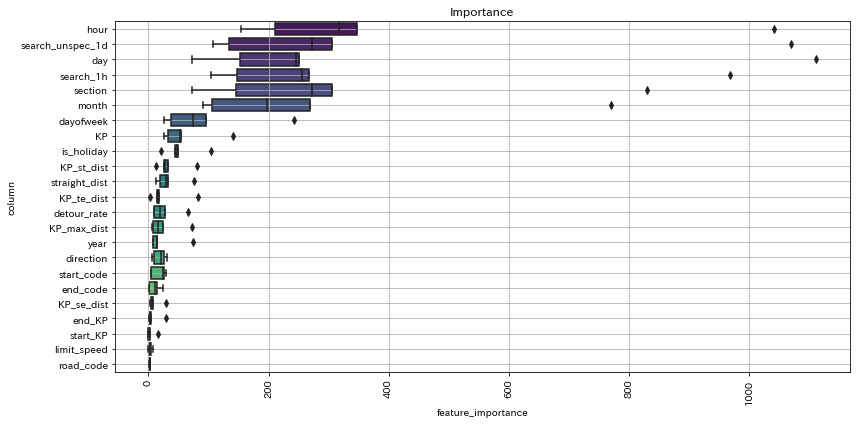

In [ ]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        importance_type = 'split'
        _df["feature_importance"] = model.feature_importance(importance_type=importance_type)
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

In [ ]:

def train_lgbm(X, y, cv):
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        train_date = x_train['date']
        #print(f'Train: {train_date.min()} >> {train_date.max()}')
        #print(x_train.shape)
        #print(y_train.value_counts())

        valid_date = x_valid['date']
        print(f'Validation: {valid_date.min()} >> {valid_date.max()}')
        #print(x_valid.shape)
        #print(y_valid.value_counts())

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols+['date']]
y = train[TARGET]

print(X.shape)
print(y.shape)

train_lgbm(X, y, cv_list)

(910080, 24)
(910080,)
Validation: 2021-04-08 00:00:00 >> 2022-07-29 00:00:00
Validation: 2021-04-09 00:00:00 >> 2022-07-31 00:00:00
Validation: 2021-04-10 00:00:00 >> 2022-07-27 00:00:00
Validation: 2021-04-13 00:00:00 >> 2022-07-30 00:00:00
Validation: 2021-04-11 00:00:00 >> 2022-07-14 00:00:00


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.8 MB/s eta 0:00:00


In [ ]:
def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100,
               weight_dict: dict=None,
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        if weight_dict is None:
            print('Don\'t use sample weight.')
            lgb_train = lgb.Dataset(x_train, y_train)
        elif weight_dict[0] == 'balance':
            print('Using sample weight. {Balance}')
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
        else:
            print('Using sample weight.')
            print(weight_dict)
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight=weight_dict, y=y_train).astype('float32'))
            
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train, 
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['Train', 'Valid'],
                          feval=lgb_f1_score,
                          num_boost_round=100000,
                          verbose_eval=-1,
                          categorical_feature=cat_cols,
                          callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
                         )# categorical_feature=categories, verbose_eval=10
        
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = f1_score(y_valid, (pred_i > 0.5).astype(int))
        print(f" - fold{i + 1} - {score:.4f} \n")
        
    score = f1_score(y, (oof_pred > 0.5).astype(int))

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models

In [ ]:
import optuna
TUNE_SEED_NUM = 1

def objective(trial):
    
    params = {
        'objective': 'binary',
        'verbose': -1,
        'metric': 'binary_logloss',
        'seed': 0,
        "force_col_wise":True,
        
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 1),
    
    }

    # ========================================
    # train-validation split
    # ========================================
    TARGET = 'is_congestion'
    N_SPLIT = 5
    kf = StratifiedGroupKFold(N_SPLIT)
    cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

    # ========================================
    # define variables
    # ========================================
    X = train[feature_cols]
    y = train[TARGET]

    vc = train['is_congestion'].value_counts()

    weight = {0:1.0, 1:5.0}
    score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)
        
    return -score
    
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2023-03-08 12:55:08,219] A new study created in memory with name: no-name-85f95731-c0aa-4c7b-891e-655cb25d4997


Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	Train's binary_logloss: 0.0129001	Train's f1: 0.80749	Valid's binary_logloss: 0.0120097	Valid's f1: 0.602885
 - fold1 - 0.6029 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	Train's binary_logloss: 0.0155298	Train's f1: 0.768116	Valid's binary_logloss: 0.0135068	Valid's f1: 0.568846
 - fold2 - 0.5688 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	Train's binary_logloss: 0.0149206	Train's f1: 0.779011	Valid's binary_logloss: 0.0140811	Valid's f1: 0.573436
 - fold3 - 0.5734 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[114]	Train's binary_logloss: 0.0177266	Train's f

[I 2023-03-08 13:06:48,855] Trial 0 finished with value: -0.5702964885913376 and parameters: {'num_leaves': 141, 'learning_rate': 0.07436704297351776, 'max_depth': 7, 'min_data_in_leaf': 55, 'feature_fraction': 0.7694619197355619, 'bagging_fraction': 0.8583576452266624, 'lambda_l1': 0.4375872112626925, 'lambda_l2': 0.8917730007820798}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5703
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	Train's binary_logloss: 0.0139486	Train's f1: 0.79632	Valid's binary_logloss: 0.0124207	Valid's f1: 0.600592
 - fold1 - 0.6006 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	Train's binary_logloss: 0.0199369	Train's f1: 0.746859	Valid's binary_logloss: 0.0146112	Valid's f1: 0.559335
 - fold2 - 0.5593 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[159]	Train's binary_logloss: 0.0123291	Train's f1: 0.822796	Valid's binary_logloss: 0.0132979	Valid's f1: 0.585683
 - fold3 - 0.5857 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[244]	Train's binary_logl

[I 2023-03-08 13:19:25,663] Trial 1 finished with value: -0.5594265232974911 and parameters: {'num_leaves': 247, 'learning_rate': 0.04450973669432, 'max_depth': 9, 'min_data_in_leaf': 53, 'feature_fraction': 0.827217824437573, 'bagging_fraction': 0.9702386553170644, 'lambda_l1': 0.07103605819788694, 'lambda_l2': 0.08712929970154071}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5594
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	Train's binary_logloss: 0.0317741	Train's f1: 0.600987	Valid's binary_logloss: 0.0162214	Valid's f1: 0.548966
 - fold1 - 0.5490 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[763]	Train's binary_logloss: 0.0196363	Train's f1: 0.709556	Valid's binary_logloss: 0.0142743	Valid's f1: 0.563674
 - fold2 - 0.5637 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	Train's binary_logloss: 0.053645	Train's f1: 0.464657	Valid's binary_logloss: 0.0245197	Valid's f1: 0.424699
 - fold3 - 0.4247 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[270]	Train's binary_logl

[I 2023-03-08 13:37:48,497] Trial 2 finished with value: -0.5060115002613695 and parameters: {'num_leaves': 7, 'learning_rate': 0.08493578609931442, 'max_depth': 9, 'min_data_in_leaf': 88, 'feature_fraction': 0.9914473368931056, 'bagging_fraction': 0.9196634256866895, 'lambda_l1': 0.46147936225293185, 'lambda_l2': 0.7805291762864555}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5060
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[270]	Train's binary_logloss: 0.0271793	Train's f1: 0.638067	Valid's binary_logloss: 0.0150478	Valid's f1: 0.550272
 - fold1 - 0.5503 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[304]	Train's binary_logloss: 0.025842	Train's f1: 0.662703	Valid's binary_logloss: 0.0157918	Valid's f1: 0.520734
 - fold2 - 0.5207 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[240]	Train's binary_logloss: 0.0282189	Train's f1: 0.610012	Valid's binary_logloss: 0.0176137	Valid's f1: 0.528053
 - fold3 - 0.5281 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[683]	Train's binary_log

[I 2023-03-08 13:56:26,199] Trial 3 finished with value: -0.5201863354037267 and parameters: {'num_leaves': 32, 'learning_rate': 0.06759289191947715, 'max_depth': 4, 'min_data_in_leaf': 95, 'feature_fraction': 0.8087393287000286, 'bagging_fraction': 0.7658647759962094, 'lambda_l1': 0.26455561210462697, 'lambda_l2': 0.7742336894342167}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5202
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[619]	Train's binary_logloss: 0.0283331	Train's f1: 0.626627	Valid's binary_logloss: 0.0156385	Valid's f1: 0.535939
 - fold1 - 0.5359 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[746]	Train's binary_logloss: 0.0260848	Train's f1: 0.649267	Valid's binary_logloss: 0.0160228	Valid's f1: 0.524209
 - fold2 - 0.5242 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[568]	Train's binary_logloss: 0.0291218	Train's f1: 0.602177	Valid's binary_logloss: 0.0181168	Valid's f1: 0.506684
 - fold3 - 0.5067 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[855]	Train's binary_lo

[I 2023-03-08 14:29:27,432] Trial 4 finished with value: -0.5195066700226529 and parameters: {'num_leaves': 118, 'learning_rate': 0.061159055398178376, 'max_depth': 3, 'min_data_in_leaf': 62, 'feature_fraction': 0.8448382890889685, 'bagging_fraction': 0.8467735987499028, 'lambda_l1': 0.9437480785146242, 'lambda_l2': 0.6818202991034834}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5195
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	Train's binary_logloss: 0.015562	Train's f1: 0.771325	Valid's binary_logloss: 0.0125552	Valid's f1: 0.597252
 - fold1 - 0.5973 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[234]	Train's binary_logloss: 0.0106668	Train's f1: 0.838342	Valid's binary_logloss: 0.0126446	Valid's f1: 0.554598
 - fold2 - 0.5546 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[252]	Train's binary_logloss: 0.0104454	Train's f1: 0.842286	Valid's binary_logloss: 0.0130405	Valid's f1: 0.580131
 - fold3 - 0.5801 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	Train's binary_log

[I 2023-03-08 14:42:47,162] Trial 5 finished with value: -0.5648252536640361 and parameters: {'num_leaves': 93, 'learning_rate': 0.04933287584194074, 'max_depth': 8, 'min_data_in_leaf': 7, 'feature_fraction': 0.8667066861782671, 'bagging_fraction': 0.8682551478472638, 'lambda_l1': 0.2103825610738409, 'lambda_l2': 0.1289262976548533}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5648
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[246]	Train's binary_logloss: 0.0152129	Train's f1: 0.778825	Valid's binary_logloss: 0.012568	Valid's f1: 0.601164
 - fold1 - 0.6012 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	Train's binary_logloss: 0.0169703	Train's f1: 0.757914	Valid's binary_logloss: 0.0137346	Valid's f1: 0.553041
 - fold2 - 0.5530 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[288]	Train's binary_logloss: 0.0131186	Train's f1: 0.797516	Valid's binary_logloss: 0.0136038	Valid's f1: 0.585366
 - fold3 - 0.5854 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[365]	Train's binary_log

[I 2023-03-08 14:59:55,088] Trial 6 finished with value: -0.5578961861489744 and parameters: {'num_leaves': 82, 'learning_rate': 0.04273396938483604, 'max_depth': 7, 'min_data_in_leaf': 44, 'feature_fraction': 0.9953495352236905, 'bagging_fraction': 0.6408179242992113, 'lambda_l1': 0.2088767560948347, 'lambda_l2': 0.16130951788499626}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5579
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[558]	Train's binary_logloss: 0.0144018	Train's f1: 0.788492	Valid's binary_logloss: 0.0125485	Valid's f1: 0.606195
 - fold1 - 0.6062 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[252]	Train's binary_logloss: 0.0233348	Train's f1: 0.686062	Valid's binary_logloss: 0.01509	Valid's f1: 0.500353
 - fold2 - 0.5004 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[548]	Train's binary_logloss: 0.0147016	Train's f1: 0.782659	Valid's binary_logloss: 0.0139971	Valid's f1: 0.56899
 - fold3 - 0.5690 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[304]	Train's binary_loglo

[I 2023-03-08 15:21:56,153] Trial 7 finished with value: -0.5426524266594565 and parameters: {'num_leaves': 168, 'learning_rate': 0.03279624422858039, 'max_depth': 6, 'min_data_in_leaf': 25, 'feature_fraction': 0.6635878334582078, 'bagging_fraction': 0.644150056465722, 'lambda_l1': 0.6563295894652734, 'lambda_l2': 0.1381829513486138}. Best is trial 0 with value: -0.5702964885913376.


FINISH: CV Score: 0.5427
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	Train's binary_logloss: 0.018084	Train's f1: 0.73344	Valid's binary_logloss: 0.0129256	Valid's f1: 0.606406
 - fold1 - 0.6064 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[125]	Train's binary_logloss: 0.0222427	Train's f1: 0.704819	Valid's binary_logloss: 0.0145093	Valid's f1: 0.560339
 - fold2 - 0.5603 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	Train's binary_logloss: 0.023064	Train's f1: 0.697122	Valid's binary_logloss: 0.0153441	Valid's f1: 0.582566
 - fold3 - 0.5826 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[326]	Train's binary_loglo

[I 2023-03-08 15:34:21,332] Trial 8 finished with value: -0.5732998885172799 and parameters: {'num_leaves': 52, 'learning_rate': 0.043185265359486774, 'max_depth': 9, 'min_data_in_leaf': 10, 'feature_fraction': 0.9351779629995216, 'bagging_fraction': 0.6384393631575852, 'lambda_l1': 0.9764594650133958, 'lambda_l2': 0.4686512016477016}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5733
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[161]	Train's binary_logloss: 0.0105005	Train's f1: 0.850171	Valid's binary_logloss: 0.0118155	Valid's f1: 0.604183
 - fold1 - 0.6042 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[118]	Train's binary_logloss: 0.0141432	Train's f1: 0.800177	Valid's binary_logloss: 0.0135719	Valid's f1: 0.518575
 - fold2 - 0.5186 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[121]	Train's binary_logloss: 0.0137645	Train's f1: 0.800933	Valid's binary_logloss: 0.0134842	Valid's f1: 0.579061
 - fold3 - 0.5791 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[210]	Train's binary_lo

[I 2023-03-08 15:46:08,814] Trial 9 finished with value: -0.5494978479196556 and parameters: {'num_leaves': 251, 'learning_rate': 0.06443609677705414, 'max_depth': 8, 'min_data_in_leaf': 4, 'feature_fraction': 0.7131227850305638, 'bagging_fraction': 0.6480786244852675, 'lambda_l1': 0.29614019752214493, 'lambda_l2': 0.11872771895424405}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5495
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[746]	Train's binary_logloss: 0.0292171	Train's f1: 0.620027	Valid's binary_logloss: 0.0160418	Valid's f1: 0.521739
 - fold1 - 0.5217 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	Train's binary_logloss: 0.0453548	Train's f1: 0.475792	Valid's binary_logloss: 0.0210296	Valid's f1: 0.443828
 - fold2 - 0.4438 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[889]	Train's binary_logloss: 0.0266455	Train's f1: 0.641321	Valid's binary_logloss: 0.0175085	Valid's f1: 0.519564
 - fold3 - 0.5196 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[667]	Train's binary_lo

[I 2023-03-08 16:12:41,898] Trial 10 finished with value: -0.501094937524153 and parameters: {'num_leaves': 83, 'learning_rate': 0.047283669506320306, 'max_depth': 3, 'min_data_in_leaf': 70, 'feature_fraction': 0.8266405816826301, 'bagging_fraction': 0.7061557963757782, 'lambda_l1': 0.5232480534666997, 'lambda_l2': 0.09394051075844168}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5011
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[376]	Train's binary_logloss: 0.0137112	Train's f1: 0.789488	Valid's binary_logloss: 0.012655	Valid's f1: 0.604483
 - fold1 - 0.6045 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	Train's binary_logloss: 0.0208687	Train's f1: 0.689071	Valid's binary_logloss: 0.0155178	Valid's f1: 0.520954
 - fold2 - 0.5210 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[276]	Train's binary_logloss: 0.0165055	Train's f1: 0.746974	Valid's binary_logloss: 0.0148327	Valid's f1: 0.575269
 - fold3 - 0.5753 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[192]	Train's binary_log

[I 2023-03-08 16:26:28,455] Trial 11 finished with value: -0.5423946557040082 and parameters: {'num_leaves': 148, 'learning_rate': 0.09363665778185927, 'max_depth': 5, 'min_data_in_leaf': 67, 'feature_fraction': 0.6527191449617569, 'bagging_fraction': 0.8865308816474262, 'lambda_l1': 0.2894060929472011, 'lambda_l2': 0.18319136200711683}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5424
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	Train's binary_logloss: 0.0246239	Train's f1: 0.73239	Valid's binary_logloss: 0.0149106	Valid's f1: 0.599681
 - fold1 - 0.5997 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[111]	Train's binary_logloss: 0.0347524	Train's f1: 0.66374	Valid's binary_logloss: 0.0193972	Valid's f1: 0.509519
 - fold2 - 0.5095 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[372]	Train's binary_logloss: 0.018592	Train's f1: 0.75652	Valid's binary_logloss: 0.0143359	Valid's f1: 0.589653
 - fold3 - 0.5897 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[418]	Train's binary_loglos

[I 2023-03-08 16:44:21,931] Trial 12 finished with value: -0.5565035174375094 and parameters: {'num_leaves': 151, 'learning_rate': 0.01180967915687442, 'max_depth': 9, 'min_data_in_leaf': 1, 'feature_fraction': 0.871126614718492, 'bagging_fraction': 0.7080031892768659, 'lambda_l1': 0.7351940221225949, 'lambda_l2': 0.9621885451174382}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5565
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	Train's binary_logloss: 0.0166654	Train's f1: 0.759461	Valid's binary_logloss: 0.0128584	Valid's f1: 0.588492
 - fold1 - 0.5885 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[130]	Train's binary_logloss: 0.019855	Train's f1: 0.729637	Valid's binary_logloss: 0.0140929	Valid's f1: 0.538296
 - fold2 - 0.5383 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[300]	Train's binary_logloss: 0.0112054	Train's f1: 0.834206	Valid's binary_logloss: 0.0135156	Valid's f1: 0.577086
 - fold3 - 0.5771 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[250]	Train's binary_log

[I 2023-03-08 16:57:20,636] Trial 13 finished with value: -0.5594978165938864 and parameters: {'num_leaves': 65, 'learning_rate': 0.06185416009760533, 'max_depth': 7, 'min_data_in_leaf': 58, 'feature_fraction': 0.6892326530562474, 'bagging_fraction': 0.981099604606794, 'lambda_l1': 0.44712537861762736, 'lambda_l2': 0.8464086724711278}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5595
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[182]	Train's binary_logloss: 0.0136424	Train's f1: 0.80126	Valid's binary_logloss: 0.0123035	Valid's f1: 0.608371
 - fold1 - 0.6084 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	Train's binary_logloss: 0.0218947	Train's f1: 0.738442	Valid's binary_logloss: 0.0150047	Valid's f1: 0.533133
 - fold2 - 0.5331 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[149]	Train's binary_logloss: 0.016172	Train's f1: 0.77939	Valid's binary_logloss: 0.0140793	Valid's f1: 0.595474
 - fold3 - 0.5955 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[342]	Train's binary_loglos

[I 2023-03-08 17:10:40,618] Trial 14 finished with value: -0.5638728323699422 and parameters: {'num_leaves': 180, 'learning_rate': 0.03676932557696203, 'max_depth': 9, 'min_data_in_leaf': 40, 'feature_fraction': 0.9524412788444646, 'bagging_fraction': 0.8325091490543435, 'lambda_l1': 0.8817353618548528, 'lambda_l2': 0.6925315900777659}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5639
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[109]	Train's binary_logloss: 0.0125749	Train's f1: 0.818844	Valid's binary_logloss: 0.0121637	Valid's f1: 0.602804
 - fold1 - 0.6028 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[131]	Train's binary_logloss: 0.0102858	Train's f1: 0.842762	Valid's binary_logloss: 0.012563	Valid's f1: 0.574661
 - fold2 - 0.5747 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	Train's binary_logloss: 0.00952468	Train's f1: 0.864078	Valid's binary_logloss: 0.0129247	Valid's f1: 0.586941
 - fold3 - 0.5869 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[88]	Train's binary_log

[I 2023-03-08 17:20:47,762] Trial 15 finished with value: -0.5720057720057721 and parameters: {'num_leaves': 186, 'learning_rate': 0.05511919437340321, 'max_depth': 10, 'min_data_in_leaf': 65, 'feature_fraction': 0.7695420194232718, 'bagging_fraction': 0.8425572856511697, 'lambda_l1': 0.019193198309333526, 'lambda_l2': 0.30157481667454933}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5720
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[311]	Train's binary_logloss: 0.0155086	Train's f1: 0.781773	Valid's binary_logloss: 0.0125542	Valid's f1: 0.600749
 - fold1 - 0.6007 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[335]	Train's binary_logloss: 0.0146844	Train's f1: 0.78286	Valid's binary_logloss: 0.013334	Valid's f1: 0.528719
 - fold2 - 0.5287 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[459]	Train's binary_logloss: 0.0112676	Train's f1: 0.832125	Valid's binary_logloss: 0.0133083	Valid's f1: 0.578417
 - fold3 - 0.5784 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[99]	Train's binary_loglo

[I 2023-03-08 17:38:00,027] Trial 16 finished with value: -0.551354401805869 and parameters: {'num_leaves': 170, 'learning_rate': 0.036106984648939966, 'max_depth': 7, 'min_data_in_leaf': 43, 'feature_fraction': 0.6541896256889801, 'bagging_fraction': 0.7193129303824123, 'lambda_l1': 0.5699649107012649, 'lambda_l2': 0.5908727612481732}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5514
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[112]	Train's binary_logloss: 0.0149992	Train's f1: 0.776579	Valid's binary_logloss: 0.0127255	Valid's f1: 0.586033
 - fold1 - 0.5860 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	Train's binary_logloss: 0.00898594	Train's f1: 0.865895	Valid's binary_logloss: 0.0128765	Valid's f1: 0.546816
 - fold2 - 0.5468 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[252]	Train's binary_logloss: 0.00683782	Train's f1: 0.903613	Valid's binary_logloss: 0.0130622	Valid's f1: 0.581845
 - fold3 - 0.5818 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	Train's binary_

[I 2023-03-08 17:51:04,919] Trial 17 finished with value: -0.5632687685564823 and parameters: {'num_leaves': 148, 'learning_rate': 0.06878807378714204, 'max_depth': 8, 'min_data_in_leaf': 44, 'feature_fraction': 0.9586186383404252, 'bagging_fraction': 0.7470247480191586, 'lambda_l1': 0.4358649252656268, 'lambda_l2': 0.8919233550156721}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5633
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[652]	Train's binary_logloss: 0.0261563	Train's f1: 0.650488	Valid's binary_logloss: 0.0153314	Valid's f1: 0.544952
 - fold1 - 0.5450 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[665]	Train's binary_logloss: 0.0256299	Train's f1: 0.660211	Valid's binary_logloss: 0.0159723	Valid's f1: 0.523118
 - fold2 - 0.5231 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[747]	Train's binary_logloss: 0.0241103	Train's f1: 0.664286	Valid's binary_logloss: 0.0167918	Valid's f1: 0.547109
 - fold3 - 0.5471 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[396]	Train's binary_lo

[I 2023-03-08 18:17:57,675] Trial 18 finished with value: -0.5240219192047916 and parameters: {'num_leaves': 207, 'learning_rate': 0.07334997251863297, 'max_depth': 3, 'min_data_in_leaf': 92, 'feature_fraction': 0.8856965198196445, 'bagging_fraction': 0.9995388026271466, 'lambda_l1': 0.14944830465799375, 'lambda_l2': 0.8681260573682142}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5240
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[643]	Train's binary_logloss: 0.0266911	Train's f1: 0.646482	Valid's binary_logloss: 0.0152582	Valid's f1: 0.541695
 - fold1 - 0.5417 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[848]	Train's binary_logloss: 0.0243577	Train's f1: 0.660203	Valid's binary_logloss: 0.015942	Valid's f1: 0.526589
 - fold2 - 0.5266 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[870]	Train's binary_logloss: 0.0235355	Train's f1: 0.665578	Valid's binary_logloss: 0.0167709	Valid's f1: 0.534745
 - fold3 - 0.5347 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[683]	Train's binary_log

[I 2023-03-08 18:51:40,570] Trial 19 finished with value: -0.529538813365519 and parameters: {'num_leaves': 43, 'learning_rate': 0.06540036078554598, 'max_depth': 3, 'min_data_in_leaf': 85, 'feature_fraction': 0.9229275834900043, 'bagging_fraction': 0.8276402954458373, 'lambda_l1': 0.40718329722599966, 'lambda_l2': 0.06916699545513805}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5295
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[301]	Train's binary_logloss: 0.00844546	Train's f1: 0.875795	Valid's binary_logloss: 0.011841	Valid's f1: 0.603008
 - fold1 - 0.6030 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[125]	Train's binary_logloss: 0.0182429	Train's f1: 0.748242	Valid's binary_logloss: 0.0143763	Valid's f1: 0.541783
 - fold2 - 0.5418 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[223]	Train's binary_logloss: 0.0107043	Train's f1: 0.842166	Valid's binary_logloss: 0.0132262	Valid's f1: 0.582688
 - fold3 - 0.5827 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	Train's binary_log

[I 2023-03-08 19:04:13,144] Trial 20 finished with value: -0.5609443891338358 and parameters: {'num_leaves': 179, 'learning_rate': 0.050818841441026205, 'max_depth': 8, 'min_data_in_leaf': 87, 'feature_fraction': 0.9902086020011543, 'bagging_fraction': 0.9423213369570445, 'lambda_l1': 0.011714084185001972, 'lambda_l2': 0.3599780644783639}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5609
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[532]	Train's binary_logloss: 0.0131348	Train's f1: 0.810315	Valid's binary_logloss: 0.0122381	Valid's f1: 0.597171
 - fold1 - 0.5972 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[565]	Train's binary_logloss: 0.0120991	Train's f1: 0.817112	Valid's binary_logloss: 0.0133218	Valid's f1: 0.532934
 - fold2 - 0.5329 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[426]	Train's binary_logloss: 0.0151262	Train's f1: 0.784474	Valid's binary_logloss: 0.0137696	Valid's f1: 0.578723
 - fold3 - 0.5787 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[543]	Train's binary_lo

[I 2023-03-08 19:29:03,481] Trial 21 finished with value: -0.5550712002324906 and parameters: {'num_leaves': 188, 'learning_rate': 0.02544667095352965, 'max_depth': 7, 'min_data_in_leaf': 6, 'feature_fraction': 0.67999860995856, 'bagging_fraction': 0.6074087177842455, 'lambda_l1': 0.7936977033574206, 'lambda_l2': 0.22392468806038013}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5551
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[113]	Train's binary_logloss: 0.0129842	Train's f1: 0.795064	Valid's binary_logloss: 0.0129368	Valid's f1: 0.574061
 - fold1 - 0.5741 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[95]	Train's binary_logloss: 0.0143558	Train's f1: 0.771506	Valid's binary_logloss: 0.014361	Valid's f1: 0.510929
 - fold2 - 0.5109 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[101]	Train's binary_logloss: 0.0136907	Train's f1: 0.782107	Valid's binary_logloss: 0.0139714	Valid's f1: 0.56984
 - fold3 - 0.5698 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[202]	Train's binary_loglo

[I 2023-03-08 19:39:00,632] Trial 22 finished with value: -0.5312960729124783 and parameters: {'num_leaves': 90, 'learning_rate': 0.09352731641190318, 'max_depth': 8, 'min_data_in_leaf': 4, 'feature_fraction': 0.665877662599165, 'bagging_fraction': 0.8485913605999054, 'lambda_l1': 0.5772285886041676, 'lambda_l2': 0.23789282137450862}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5313
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[124]	Train's binary_logloss: 0.0180635	Train's f1: 0.737643	Valid's binary_logloss: 0.0132781	Valid's f1: 0.591793
 - fold1 - 0.5918 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[99]	Train's binary_logloss: 0.021487	Train's f1: 0.714811	Valid's binary_logloss: 0.0147991	Valid's f1: 0.535231
 - fold2 - 0.5352 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	Train's binary_logloss: 0.0150619	Train's f1: 0.776128	Valid's binary_logloss: 0.0140342	Valid's f1: 0.591966
 - fold3 - 0.5920 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[298]	Train's binary_logl

[I 2023-03-08 19:50:30,640] Trial 23 finished with value: -0.5636286079909001 and parameters: {'num_leaves': 240, 'learning_rate': 0.06525693603693064, 'max_depth': 7, 'min_data_in_leaf': 59, 'feature_fraction': 0.8920488118067078, 'bagging_fraction': 0.7247779981918407, 'lambda_l1': 0.3982210622160919, 'lambda_l2': 0.20984374897512215}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5636
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	Train's binary_logloss: 0.0130528	Train's f1: 0.800453	Valid's binary_logloss: 0.0123171	Valid's f1: 0.597701
 - fold1 - 0.5977 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[141]	Train's binary_logloss: 0.0150142	Train's f1: 0.762458	Valid's binary_logloss: 0.0136524	Valid's f1: 0.541082
 - fold2 - 0.5411 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	Train's binary_logloss: 0.0193118	Train's f1: 0.692437	Valid's binary_logloss: 0.0151983	Valid's f1: 0.558262
 - fold3 - 0.5583 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[232]	Train's binary_log

[I 2023-03-08 20:00:50,069] Trial 24 finished with value: -0.5456718003186405 and parameters: {'num_leaves': 49, 'learning_rate': 0.09499351509855403, 'max_depth': 8, 'min_data_in_leaf': 50, 'feature_fraction': 0.6909658511893293, 'bagging_fraction': 0.7017425927081572, 'lambda_l1': 0.05802916032387562, 'lambda_l2': 0.4344166255581208}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5457
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[351]	Train's binary_logloss: 0.0113082	Train's f1: 0.827741	Valid's binary_logloss: 0.012272	Valid's f1: 0.618102
 - fold1 - 0.6181 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[191]	Train's binary_logloss: 0.0174956	Train's f1: 0.741134	Valid's binary_logloss: 0.0143172	Valid's f1: 0.517241
 - fold2 - 0.5172 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[318]	Train's binary_logloss: 0.0126848	Train's f1: 0.813196	Valid's binary_logloss: 0.0138404	Valid's f1: 0.574696
 - fold3 - 0.5747 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[225]	Train's binary_log

[I 2023-03-08 20:15:59,385] Trial 25 finished with value: -0.5462050599201065 and parameters: {'num_leaves': 81, 'learning_rate': 0.07267091399339136, 'max_depth': 6, 'min_data_in_leaf': 18, 'feature_fraction': 0.6098714913565325, 'bagging_fraction': 0.6268998525852995, 'lambda_l1': 0.6793927734985673, 'lambda_l2': 0.4536968445560453}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5462
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[116]	Train's binary_logloss: 0.00815215	Train's f1: 0.877252	Valid's binary_logloss: 0.0118774	Valid's f1: 0.600302
 - fold1 - 0.6003 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	Train's binary_logloss: 0.00667445	Train's f1: 0.902642	Valid's binary_logloss: 0.0130755	Valid's f1: 0.519685
 - fold2 - 0.5197 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[136]	Train's binary_logloss: 0.00709983	Train's f1: 0.898377	Valid's binary_logloss: 0.0132139	Valid's f1: 0.560117
 - fold3 - 0.5601 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	Train's binary_

[I 2023-03-08 20:26:20,612] Trial 26 finished with value: -0.562508869022279 and parameters: {'num_leaves': 138, 'learning_rate': 0.0907004163736308, 'max_depth': 10, 'min_data_in_leaf': 22, 'feature_fraction': 0.8652312812400402, 'bagging_fraction': 0.7053289506948602, 'lambda_l1': 0.02065099946572868, 'lambda_l2': 0.7583786538361414}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5625
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	Train's binary_logloss: 0.0171914	Train's f1: 0.753988	Valid's binary_logloss: 0.0126926	Valid's f1: 0.606106
 - fold1 - 0.6061 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[221]	Train's binary_logloss: 0.0165742	Train's f1: 0.761821	Valid's binary_logloss: 0.0134861	Valid's f1: 0.54247
 - fold2 - 0.5425 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	Train's binary_logloss: 0.0200341	Train's f1: 0.722256	Valid's binary_logloss: 0.0147094	Valid's f1: 0.585987
 - fold3 - 0.5860 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[316]	Train's binary_log

[I 2023-03-08 20:40:14,557] Trial 27 finished with value: -0.5657728485188823 and parameters: {'num_leaves': 83, 'learning_rate': 0.044511750475470825, 'max_depth': 7, 'min_data_in_leaf': 84, 'feature_fraction': 0.8515927374364595, 'bagging_fraction': 0.9490602621789581, 'lambda_l1': 0.27354203481563577, 'lambda_l2': 0.7980468339125637}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5658
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	Train's binary_logloss: 0.013393	Train's f1: 0.779358	Valid's binary_logloss: 0.012902	Valid's f1: 0.563815
 - fold1 - 0.5638 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	Train's binary_logloss: 0.0109575	Train's f1: 0.827731	Valid's binary_logloss: 0.0133459	Valid's f1: 0.527738
 - fold2 - 0.5277 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[263]	Train's binary_logloss: 0.00843751	Train's f1: 0.877557	Valid's binary_logloss: 0.0135821	Valid's f1: 0.570207
 - fold3 - 0.5702 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[283]	Train's binary_log

[I 2023-03-08 20:53:08,399] Trial 28 finished with value: -0.5500630163842599 and parameters: {'num_leaves': 49, 'learning_rate': 0.09575124912747501, 'max_depth': 8, 'min_data_in_leaf': 22, 'feature_fraction': 0.9789482361955697, 'bagging_fraction': 0.8923423227080631, 'lambda_l1': 0.25394164259502583, 'lambda_l2': 0.21331197736748198}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5501
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[74]	Train's binary_logloss: 0.0641217	Train's f1: 0.394879	Valid's binary_logloss: 0.0267339	Valid's f1: 0.466019
 - fold1 - 0.4660 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[348]	Train's binary_logloss: 0.043285	Train's f1: 0.505079	Valid's binary_logloss: 0.0203397	Valid's f1: 0.433159
 - fold2 - 0.4332 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1023]	Train's binary_logloss: 0.0304455	Train's f1: 0.592546	Valid's binary_logloss: 0.0177582	Valid's f1: 0.52102
 - fold3 - 0.5210 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[778]	Train's binary_logl

[I 2023-03-08 21:19:16,915] Trial 29 finished with value: -0.4790331974373908 and parameters: {'num_leaves': 134, 'learning_rate': 0.012309644624907842, 'max_depth': 4, 'min_data_in_leaf': 43, 'feature_fraction': 0.7496679921336902, 'bagging_fraction': 0.7854301697459243, 'lambda_l1': 0.2776287062947319, 'lambda_l2': 0.5867843464581688}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.4790
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[590]	Train's binary_logloss: 0.0136076	Train's f1: 0.797863	Valid's binary_logloss: 0.0121326	Valid's f1: 0.61367
 - fold1 - 0.6137 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[511]	Train's binary_logloss: 0.0149302	Train's f1: 0.783182	Valid's binary_logloss: 0.0130689	Valid's f1: 0.554913
 - fold2 - 0.5549 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[633]	Train's binary_logloss: 0.0126724	Train's f1: 0.811506	Valid's binary_logloss: 0.0135082	Valid's f1: 0.582857
 - fold3 - 0.5829 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	Train's binary_log

[I 2023-03-08 21:44:59,397] Trial 30 finished with value: -0.563013310676862 and parameters: {'num_leaves': 222, 'learning_rate': 0.02057786703658298, 'max_depth': 7, 'min_data_in_leaf': 14, 'feature_fraction': 0.8867438724770375, 'bagging_fraction': 0.7584238811229175, 'lambda_l1': 0.565421311858509, 'lambda_l2': 0.18327983621407862}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5630
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[142]	Train's binary_logloss: 0.0298685	Train's f1: 0.626695	Valid's binary_logloss: 0.015604	Valid's f1: 0.541963
 - fold1 - 0.5420 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[355]	Train's binary_logloss: 0.0196092	Train's f1: 0.705882	Valid's binary_logloss: 0.0146602	Valid's f1: 0.504313
 - fold2 - 0.5043 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[556]	Train's binary_logloss: 0.014309	Train's f1: 0.780914	Valid's binary_logloss: 0.014345	Valid's f1: 0.570845
 - fold3 - 0.5708 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[357]	Train's binary_loglo

[I 2023-03-08 22:02:42,383] Trial 31 finished with value: -0.5305183380701042 and parameters: {'num_leaves': 38, 'learning_rate': 0.053925065258405916, 'max_depth': 5, 'min_data_in_leaf': 95, 'feature_fraction': 0.9061301015227861, 'bagging_fraction': 0.8994654479402189, 'lambda_l1': 0.9037197397459334, 'lambda_l2': 0.08342243544201855}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5305
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	Train's binary_logloss: 0.0110579	Train's f1: 0.836307	Valid's binary_logloss: 0.0118858	Valid's f1: 0.58492
 - fold1 - 0.5849 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	Train's binary_logloss: 0.0181456	Train's f1: 0.760409	Valid's binary_logloss: 0.0139759	Valid's f1: 0.564334
 - fold2 - 0.5643 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[107]	Train's binary_logloss: 0.0124212	Train's f1: 0.819001	Valid's binary_logloss: 0.0133934	Valid's f1: 0.583799
 - fold3 - 0.5838 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[102]	Train's binary_logl

[I 2023-03-08 22:11:57,299] Trial 32 finished with value: -0.5635903207653348 and parameters: {'num_leaves': 142, 'learning_rate': 0.0626028462060192, 'max_depth': 10, 'min_data_in_leaf': 30, 'feature_fraction': 0.6963315119661787, 'bagging_fraction': 0.6401175769061991, 'lambda_l1': 0.016429629591474204, 'lambda_l2': 0.9295293167921905}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5636
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[200]	Train's binary_logloss: 0.0225721	Train's f1: 0.692742	Valid's binary_logloss: 0.0144173	Valid's f1: 0.575881
 - fold1 - 0.5759 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[129]	Train's binary_logloss: 0.0278149	Train's f1: 0.633402	Valid's binary_logloss: 0.0164365	Valid's f1: 0.509987
 - fold2 - 0.5100 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[372]	Train's binary_logloss: 0.0158213	Train's f1: 0.758275	Valid's binary_logloss: 0.0144903	Valid's f1: 0.565004
 - fold3 - 0.5650 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[407]	Train's binary_lo

[I 2023-03-08 22:26:29,755] Trial 33 finished with value: -0.5356309924850998 and parameters: {'num_leaves': 172, 'learning_rate': 0.0806637620820824, 'max_depth': 5, 'min_data_in_leaf': 59, 'feature_fraction': 0.6255821064483924, 'bagging_fraction': 0.7942510383738491, 'lambda_l1': 0.9774951397444468, 'lambda_l2': 0.8765052453165908}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5356
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[388]	Train's binary_logloss: 0.0199659	Train's f1: 0.70373	Valid's binary_logloss: 0.013874	Valid's f1: 0.555037
 - fold1 - 0.5550 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[203]	Train's binary_logloss: 0.0260933	Train's f1: 0.630287	Valid's binary_logloss: 0.0159197	Valid's f1: 0.515924
 - fold2 - 0.5159 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[476]	Train's binary_logloss: 0.0174772	Train's f1: 0.738846	Valid's binary_logloss: 0.01534	Valid's f1: 0.54595
 - fold3 - 0.5459 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[344]	Train's binary_logloss

[I 2023-03-08 22:43:46,868] Trial 34 finished with value: -0.5183514969309783 and parameters: {'num_leaves': 88, 'learning_rate': 0.09654131390873487, 'max_depth': 4, 'min_data_in_leaf': 95, 'feature_fraction': 0.9765510818825994, 'bagging_fraction': 0.9196810349409567, 'lambda_l1': 0.6304479368667911, 'lambda_l2': 0.874287966624947}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5184
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	Train's binary_logloss: 0.0120712	Train's f1: 0.817926	Valid's binary_logloss: 0.01232	Valid's f1: 0.588825
 - fold1 - 0.5888 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[159]	Train's binary_logloss: 0.0131743	Train's f1: 0.79513	Valid's binary_logloss: 0.0141408	Valid's f1: 0.484406
 - fold2 - 0.4844 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[152]	Train's binary_logloss: 0.0138361	Train's f1: 0.790507	Valid's binary_logloss: 0.0138397	Valid's f1: 0.571429
 - fold3 - 0.5714 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[231]	Train's binary_loglo

[I 2023-03-08 22:55:33,785] Trial 35 finished with value: -0.5279511353073961 and parameters: {'num_leaves': 76, 'learning_rate': 0.08640491997816264, 'max_depth': 7, 'min_data_in_leaf': 2, 'feature_fraction': 0.7388934071728879, 'bagging_fraction': 0.659256344379266, 'lambda_l1': 0.9818293898182532, 'lambda_l2': 0.47837030703998806}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5280
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[574]	Train's binary_logloss: 0.0121677	Train's f1: 0.810674	Valid's binary_logloss: 0.0126898	Valid's f1: 0.579985
 - fold1 - 0.5800 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[552]	Train's binary_logloss: 0.0124381	Train's f1: 0.803993	Valid's binary_logloss: 0.0137121	Valid's f1: 0.540103
 - fold2 - 0.5401 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[299]	Train's binary_logloss: 0.0181914	Train's f1: 0.729698	Valid's binary_logloss: 0.0154836	Valid's f1: 0.528121
 - fold3 - 0.5281 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	Train's binary_lo

[I 2023-03-08 23:15:44,431] Trial 36 finished with value: -0.5325584467045305 and parameters: {'num_leaves': 128, 'learning_rate': 0.06755252647588512, 'max_depth': 5, 'min_data_in_leaf': 14, 'feature_fraction': 0.9288470932776982, 'bagging_fraction': 0.6759391647611032, 'lambda_l1': 0.511318982546456, 'lambda_l2': 0.22431702897473926}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5326
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[114]	Train's binary_logloss: 0.0221603	Train's f1: 0.67802	Valid's binary_logloss: 0.0142656	Valid's f1: 0.564865
 - fold1 - 0.5649 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[109]	Train's binary_logloss: 0.0218698	Train's f1: 0.679043	Valid's binary_logloss: 0.0154637	Valid's f1: 0.524129
 - fold2 - 0.5241 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[264]	Train's binary_logloss: 0.0137042	Train's f1: 0.783193	Valid's binary_logloss: 0.0141062	Valid's f1: 0.568883
 - fold3 - 0.5689 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[375]	Train's binary_log

[I 2023-03-08 23:29:01,708] Trial 37 finished with value: -0.545218632412093 and parameters: {'num_leaves': 26, 'learning_rate': 0.0875972365679515, 'max_depth': 10, 'min_data_in_leaf': 97, 'feature_fraction': 0.9626221996884716, 'bagging_fraction': 0.9096189330794555, 'lambda_l1': 0.3331451520286419, 'lambda_l2': 0.08110138998799676}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5452
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[853]	Train's binary_logloss: 0.0233969	Train's f1: 0.679186	Valid's binary_logloss: 0.014167	Valid's f1: 0.5722
 - fold1 - 0.5722 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[508]	Train's binary_logloss: 0.0282263	Train's f1: 0.639903	Valid's binary_logloss: 0.016407	Valid's f1: 0.484085
 - fold2 - 0.4841 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[521]	Train's binary_logloss: 0.0274725	Train's f1: 0.618209	Valid's binary_logloss: 0.0170715	Valid's f1: 0.522148
 - fold3 - 0.5221 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[691]	Train's binary_loglos

[I 2023-03-08 23:59:06,173] Trial 38 finished with value: -0.5171421093954462 and parameters: {'num_leaves': 105, 'learning_rate': 0.03090107279538485, 'max_depth': 4, 'min_data_in_leaf': 6, 'feature_fraction': 0.8902377456842314, 'bagging_fraction': 0.6045709834500124, 'lambda_l1': 0.7705807485027762, 'lambda_l2': 0.14694664540037505}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5171
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[349]	Train's binary_logloss: 0.0302911	Train's f1: 0.633349	Valid's binary_logloss: 0.0157658	Valid's f1: 0.555079
 - fold1 - 0.5551 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[656]	Train's binary_logloss: 0.0232481	Train's f1: 0.680636	Valid's binary_logloss: 0.0150399	Valid's f1: 0.523378
 - fold2 - 0.5234 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[391]	Train's binary_logloss: 0.027865	Train's f1: 0.64124	Valid's binary_logloss: 0.016514	Valid's f1: 0.551181
 - fold3 - 0.5512 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	Train's binary_loglo

[I 2023-03-09 00:22:17,260] Trial 39 finished with value: -0.5267144596239687 and parameters: {'num_leaves': 22, 'learning_rate': 0.018064273081474486, 'max_depth': 8, 'min_data_in_leaf': 25, 'feature_fraction': 0.7682157866720394, 'bagging_fraction': 0.8229475165295668, 'lambda_l1': 0.8605511738287938, 'lambda_l2': 0.7270442627113283}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5267
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[91]	Train's binary_logloss: 0.0617333	Train's f1: 0.407212	Valid's binary_logloss: 0.0259571	Valid's f1: 0.460724
 - fold1 - 0.4607 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[500]	Train's binary_logloss: 0.0415485	Train's f1: 0.496284	Valid's binary_logloss: 0.0199894	Valid's f1: 0.423913
 - fold2 - 0.4239 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[477]	Train's binary_logloss: 0.0414205	Train's f1: 0.502206	Valid's binary_logloss: 0.0212477	Valid's f1: 0.438356
 - fold3 - 0.4384 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[828]	Train's binary_log

[I 2023-03-09 00:44:55,899] Trial 40 finished with value: -0.4542524870393723 and parameters: {'num_leaves': 70, 'learning_rate': 0.021833451936201488, 'max_depth': 3, 'min_data_in_leaf': 31, 'feature_fraction': 0.7048472596958713, 'bagging_fraction': 0.7824562267201919, 'lambda_l1': 0.6832813355476804, 'lambda_l2': 0.6956254456388572}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.4543
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[585]	Train's binary_logloss: 0.0249064	Train's f1: 0.667921	Valid's binary_logloss: 0.0145963	Valid's f1: 0.563094
 - fold1 - 0.5631 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	Train's binary_logloss: 0.0439663	Train's f1: 0.519517	Valid's binary_logloss: 0.0205735	Valid's f1: 0.465918
 - fold2 - 0.4659 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[747]	Train's binary_logloss: 0.0216392	Train's f1: 0.68445	Valid's binary_logloss: 0.0160127	Valid's f1: 0.541833
 - fold3 - 0.5418 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[616]	Train's binary_logl

[I 2023-03-09 01:09:02,184] Trial 41 finished with value: -0.5235547435730131 and parameters: {'num_leaves': 74, 'learning_rate': 0.04419342603101085, 'max_depth': 4, 'min_data_in_leaf': 79, 'feature_fraction': 0.622739230573296, 'bagging_fraction': 0.8787988966899949, 'lambda_l1': 0.7786953959411034, 'lambda_l2': 0.7774075618487531}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5236
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[242]	Train's binary_logloss: 0.015376	Train's f1: 0.769919	Valid's binary_logloss: 0.0126196	Valid's f1: 0.606928
 - fold1 - 0.6069 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[222]	Train's binary_logloss: 0.0163146	Train's f1: 0.764352	Valid's binary_logloss: 0.0136123	Valid's f1: 0.536158
 - fold2 - 0.5362 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[275]	Train's binary_logloss: 0.0142684	Train's f1: 0.788107	Valid's binary_logloss: 0.0137184	Valid's f1: 0.578348
 - fold3 - 0.5783 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	Train's binary_log

[I 2023-03-09 01:23:17,950] Trial 42 finished with value: -0.5617198335644938 and parameters: {'num_leaves': 68, 'learning_rate': 0.04364318241393054, 'max_depth': 7, 'min_data_in_leaf': 28, 'feature_fraction': 0.7483411196871554, 'bagging_fraction': 0.6788217120742559, 'lambda_l1': 0.4598558837560074, 'lambda_l2': 0.044612301254114084}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5617
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[530]	Train's binary_logloss: 0.0169058	Train's f1: 0.758621	Valid's binary_logloss: 0.0126628	Valid's f1: 0.605302
 - fold1 - 0.6053 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[523]	Train's binary_logloss: 0.0171804	Train's f1: 0.756933	Valid's binary_logloss: 0.0134589	Valid's f1: 0.560639
 - fold2 - 0.5606 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[599]	Train's binary_logloss: 0.0151432	Train's f1: 0.778315	Valid's binary_logloss: 0.0138498	Valid's f1: 0.584572
 - fold3 - 0.5846 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[827]	Train's binary_lo

[I 2023-03-09 01:55:40,759] Trial 43 finished with value: -0.5699353596479163 and parameters: {'num_leaves': 205, 'learning_rate': 0.016926080228796946, 'max_depth': 7, 'min_data_in_leaf': 31, 'feature_fraction': 0.8310171795325502, 'bagging_fraction': 0.98377333633337, 'lambda_l1': 0.6455702444560039, 'lambda_l2': 0.03536243575549092}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5699
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[213]	Train's binary_logloss: 0.0146933	Train's f1: 0.78498	Valid's binary_logloss: 0.0123148	Valid's f1: 0.614467
 - fold1 - 0.6145 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	Train's binary_logloss: 0.0136098	Train's f1: 0.794286	Valid's binary_logloss: 0.0129518	Valid's f1: 0.562319
 - fold2 - 0.5623 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[245]	Train's binary_logloss: 0.0130267	Train's f1: 0.807484	Valid's binary_logloss: 0.0137451	Valid's f1: 0.581461
 - fold3 - 0.5815 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[344]	Train's binary_log

[I 2023-03-09 02:11:16,805] Trial 44 finished with value: -0.5695766101227416 and parameters: {'num_leaves': 111, 'learning_rate': 0.055901516708642525, 'max_depth': 7, 'min_data_in_leaf': 69, 'feature_fraction': 0.7110384390927065, 'bagging_fraction': 0.6515442261865281, 'lambda_l1': 0.39267567654709434, 'lambda_l2': 0.9564057227959488}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5696
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	Train's binary_logloss: 0.0130399	Train's f1: 0.800561	Valid's binary_logloss: 0.0123166	Valid's f1: 0.590876
 - fold1 - 0.5909 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	Train's binary_logloss: 0.0112671	Train's f1: 0.827712	Valid's binary_logloss: 0.0131048	Valid's f1: 0.543446
 - fold2 - 0.5434 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[115]	Train's binary_logloss: 0.0171857	Train's f1: 0.738255	Valid's binary_logloss: 0.0141751	Valid's f1: 0.576503
 - fold3 - 0.5765 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[284]	Train's binary_lo

[I 2023-03-09 02:23:59,058] Trial 45 finished with value: -0.5448691026179476 and parameters: {'num_leaves': 49, 'learning_rate': 0.09135855594354134, 'max_depth': 7, 'min_data_in_leaf': 46, 'feature_fraction': 0.9528165640919558, 'bagging_fraction': 0.7834415847074343, 'lambda_l1': 0.7241676366115433, 'lambda_l2': 0.399025321703102}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5449
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	Train's binary_logloss: 0.0107052	Train's f1: 0.841524	Valid's binary_logloss: 0.0121512	Valid's f1: 0.595522
 - fold1 - 0.5955 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[50]	Train's binary_logloss: 0.0230153	Train's f1: 0.708586	Valid's binary_logloss: 0.0153484	Valid's f1: 0.544248
 - fold2 - 0.5442 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	Train's binary_logloss: 0.0109624	Train's f1: 0.838617	Valid's binary_logloss: 0.013381	Valid's f1: 0.576978
 - fold3 - 0.5770 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[165]	Train's binary_logl

[I 2023-03-09 02:34:19,490] Trial 46 finished with value: -0.562004530011325 and parameters: {'num_leaves': 232, 'learning_rate': 0.07210225181721047, 'max_depth': 8, 'min_data_in_leaf': 33, 'feature_fraction': 0.9027114570947556, 'bagging_fraction': 0.8544244221788565, 'lambda_l1': 0.24002027337970955, 'lambda_l2': 0.16053882248525642}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5620
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[222]	Train's binary_logloss: 0.0124891	Train's f1: 0.80497	Valid's binary_logloss: 0.0125105	Valid's f1: 0.594045
 - fold1 - 0.5940 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[258]	Train's binary_logloss: 0.0114735	Train's f1: 0.820211	Valid's binary_logloss: 0.0133923	Valid's f1: 0.530259
 - fold2 - 0.5303 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[407]	Train's binary_logloss: 0.00755183	Train's f1: 0.88455	Valid's binary_logloss: 0.0138474	Valid's f1: 0.557763
 - fold3 - 0.5578 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[205]	Train's binary_log

[I 2023-03-09 02:49:27,186] Trial 47 finished with value: -0.5429086371828642 and parameters: {'num_leaves': 205, 'learning_rate': 0.09632499427317003, 'max_depth': 6, 'min_data_in_leaf': 60, 'feature_fraction': 0.9430890576774218, 'bagging_fraction': 0.7828893813415428, 'lambda_l1': 0.9518744768327362, 'lambda_l2': 0.5757511620448724}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5429
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	Train's binary_logloss: 0.021328	Train's f1: 0.730919	Valid's binary_logloss: 0.0148919	Valid's f1: 0.573343
 - fold1 - 0.5733 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	Train's binary_logloss: 0.00770259	Train's f1: 0.889266	Valid's binary_logloss: 0.0128536	Valid's f1: 0.530102
 - fold2 - 0.5301 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[119]	Train's binary_logloss: 0.00703197	Train's f1: 0.899585	Valid's binary_logloss: 0.0129664	Valid's f1: 0.571221
 - fold3 - 0.5712 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[97]	Train's binary_log

[I 2023-03-09 02:59:15,189] Trial 48 finished with value: -0.5524222704266089 and parameters: {'num_leaves': 211, 'learning_rate': 0.09179593465714646, 'max_depth': 9, 'min_data_in_leaf': 16, 'feature_fraction': 0.8515593756246802, 'bagging_fraction': 0.7593737034478708, 'lambda_l1': 0.0627129520233457, 'lambda_l2': 0.42403225188984195}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5524
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[787]	Train's binary_logloss: 0.0227302	Train's f1: 0.681388	Valid's binary_logloss: 0.0146511	Valid's f1: 0.551629
 - fold1 - 0.5516 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[461]	Train's binary_logloss: 0.0278054	Train's f1: 0.621641	Valid's binary_logloss: 0.0167292	Valid's f1: 0.504425
 - fold2 - 0.5044 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[564]	Train's binary_logloss: 0.025451	Train's f1: 0.649506	Valid's binary_logloss: 0.0170885	Valid's f1: 0.538562
 - fold3 - 0.5386 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[253]	Train's binary_log

[I 2023-03-09 03:24:01,877] Trial 49 finished with value: -0.5189351331083615 and parameters: {'num_leaves': 67, 'learning_rate': 0.08641344775856598, 'max_depth': 3, 'min_data_in_leaf': 96, 'feature_fraction': 0.7421475393887719, 'bagging_fraction': 0.7426827561610172, 'lambda_l1': 0.01632850268370789, 'lambda_l2': 0.18523232523618394}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5189
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[666]	Train's binary_logloss: 0.023125	Train's f1: 0.673063	Valid's binary_logloss: 0.0148445	Valid's f1: 0.555787
 - fold1 - 0.5558 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[473]	Train's binary_logloss: 0.0263824	Train's f1: 0.638088	Valid's binary_logloss: 0.0163156	Valid's f1: 0.516209
 - fold2 - 0.5162 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[603]	Train's binary_logloss: 0.0235968	Train's f1: 0.666369	Valid's binary_logloss: 0.0168379	Valid's f1: 0.537869
 - fold3 - 0.5379 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[584]	Train's binary_log

[I 2023-03-09 03:50:06,599] Trial 50 finished with value: -0.5289773438477907 and parameters: {'num_leaves': 104, 'learning_rate': 0.09363622755724425, 'max_depth': 3, 'min_data_in_leaf': 95, 'feature_fraction': 0.9477954122186529, 'bagging_fraction': 0.7816649587630207, 'lambda_l1': 0.32670088176826007, 'lambda_l2': 0.23274412927905685}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5290
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.102351	Train's f1: 0	Valid's binary_logloss: 0.0376085	Valid's f1: 0
 - fold1 - 0.0000 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[461]	Train's binary_logloss: 0.0482866	Train's f1: 0.468197	Valid's binary_logloss: 0.0219918	Valid's f1: 0.412744
 - fold2 - 0.4127 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[372]	Train's binary_logloss: 0.050646	Train's f1: 0.464518	Valid's binary_logloss: 0.0240813	Valid's f1: 0.423477
 - fold3 - 0.4235 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1052]	Train's binary_logloss: 0.0376294	

[I 2023-03-09 04:18:05,708] Trial 51 finished with value: -0.40114268531047964 and parameters: {'num_leaves': 158, 'learning_rate': 0.012976713232795506, 'max_depth': 3, 'min_data_in_leaf': 43, 'feature_fraction': 0.627229629589888, 'bagging_fraction': 0.7007763952984372, 'lambda_l1': 0.22116091534608384, 'lambda_l2': 0.2531911937228519}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.4011
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	Train's binary_logloss: 0.10291	Train's f1: 0	Valid's binary_logloss: 0.037729	Valid's f1: 0
 - fold1 - 0.0000 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[521]	Train's binary_logloss: 0.0479537	Train's f1: 0.462734	Valid's binary_logloss: 0.0218405	Valid's f1: 0.441558
 - fold2 - 0.4416 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[798]	Train's binary_logloss: 0.0432978	Train's f1: 0.484548	Valid's binary_logloss: 0.0219958	Valid's f1: 0.431479
 - fold3 - 0.4315 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[411]	Train's binary_logloss: 0.0485643	Tr

[I 2023-03-09 04:38:33,811] Trial 52 finished with value: -0.36206615610233017 and parameters: {'num_leaves': 35, 'learning_rate': 0.011083260060788885, 'max_depth': 3, 'min_data_in_leaf': 62, 'feature_fraction': 0.9897024851272201, 'bagging_fraction': 0.9961380006243575, 'lambda_l1': 0.4090540953730616, 'lambda_l2': 0.16295442604660537}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.3621
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[110]	Train's binary_logloss: 0.0125882	Train's f1: 0.807763	Valid's binary_logloss: 0.0122563	Valid's f1: 0.602392
 - fold1 - 0.6024 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[190]	Train's binary_logloss: 0.00731474	Train's f1: 0.896288	Valid's binary_logloss: 0.0123837	Valid's f1: 0.543361
 - fold2 - 0.5434 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[174]	Train's binary_logloss: 0.00799395	Train's f1: 0.884265	Valid's binary_logloss: 0.0128465	Valid's f1: 0.581159
 - fold3 - 0.5812 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[186]	Train's binary_

[I 2023-03-09 04:54:00,904] Trial 53 finished with value: -0.5619282706548568 and parameters: {'num_leaves': 164, 'learning_rate': 0.05412748118938635, 'max_depth': 10, 'min_data_in_leaf': 7, 'feature_fraction': 0.9132937753255252, 'bagging_fraction': 0.7153593989325976, 'lambda_l1': 0.241418620076574, 'lambda_l2': 0.662504571532676}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5619
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[167]	Train's binary_logloss: 0.0150854	Train's f1: 0.774175	Valid's binary_logloss: 0.0123774	Valid's f1: 0.612215
 - fold1 - 0.6122 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	Train's binary_logloss: 0.0146025	Train's f1: 0.770576	Valid's binary_logloss: 0.013398	Valid's f1: 0.53719
 - fold2 - 0.5372 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[166]	Train's binary_logloss: 0.0148564	Train's f1: 0.77061	Valid's binary_logloss: 0.0141035	Valid's f1: 0.589459
 - fold3 - 0.5895 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[295]	Train's binary_loglo

[I 2023-03-09 05:08:16,710] Trial 54 finished with value: -0.5674293405114401 and parameters: {'num_leaves': 64, 'learning_rate': 0.0699273205803269, 'max_depth': 7, 'min_data_in_leaf': 43, 'feature_fraction': 0.8218751234645676, 'bagging_fraction': 0.7148206079678519, 'lambda_l1': 0.7065747062729789, 'lambda_l2': 0.414856869333564}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5674
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[187]	Train's binary_logloss: 0.00852315	Train's f1: 0.875123	Valid's binary_logloss: 0.0120664	Valid's f1: 0.566149
 - fold1 - 0.5661 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[129]	Train's binary_logloss: 0.0111213	Train's f1: 0.822225	Valid's binary_logloss: 0.0133195	Valid's f1: 0.516997
 - fold2 - 0.5170 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	Train's binary_logloss: 0.0271344	Train's f1: 0.675956	Valid's binary_logloss: 0.0170803	Valid's f1: 0.570021
 - fold3 - 0.5700 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[149]	Train's binary_lo

[I 2023-03-09 05:18:55,879] Trial 55 finished with value: -0.5473885176598936 and parameters: {'num_leaves': 93, 'learning_rate': 0.08457912231001641, 'max_depth': 10, 'min_data_in_leaf': 5, 'feature_fraction': 0.6930507971319062, 'bagging_fraction': 0.7394077477970253, 'lambda_l1': 0.8149664793702474, 'lambda_l2': 0.9854914276432976}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5474
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	Train's binary_logloss: 0.0186827	Train's f1: 0.727299	Valid's binary_logloss: 0.0135165	Valid's f1: 0.565881
 - fold1 - 0.5659 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	Train's binary_logloss: 0.035105	Train's f1: 0.571246	Valid's binary_logloss: 0.0179569	Valid's f1: 0.507628
 - fold2 - 0.5076 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[333]	Train's binary_logloss: 0.0148393	Train's f1: 0.770658	Valid's binary_logloss: 0.0143106	Valid's f1: 0.577446
 - fold3 - 0.5774 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[380]	Train's binary_logl

[I 2023-03-09 05:33:54,716] Trial 56 finished with value: -0.5361824855794441 and parameters: {'num_leaves': 249, 'learning_rate': 0.09144535109949342, 'max_depth': 5, 'min_data_in_leaf': 100, 'feature_fraction': 0.6997680164225805, 'bagging_fraction': 0.6423624619528928, 'lambda_l1': 0.9509526110553941, 'lambda_l2': 0.2334202554680963}. Best is trial 8 with value: -0.5732998885172799.


FINISH: CV Score: 0.5362
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[624]	Train's binary_logloss: 0.0138582	Train's f1: 0.801036	Valid's binary_logloss: 0.0120276	Valid's f1: 0.61678
 - fold1 - 0.6168 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[579]	Train's binary_logloss: 0.0141638	Train's f1: 0.79738	Valid's binary_logloss: 0.0131067	Valid's f1: 0.536296
 - fold2 - 0.5363 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.


In [ ]:
"""
{'num_leaves': 52, 'learning_rate': 0.043185265359486774, 'max_depth': 9, 'min_data_in_leaf': 10, 'feature_fraction': 0.9351779629995216, 'bagging_fraction': 0.6384393631575852, 'lambda_l1': 0.9764594650133958, 'lambda_l2': 0.4686512016477016}
"""